## Lab 3

### Part 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os


%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd drive/My Drive

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


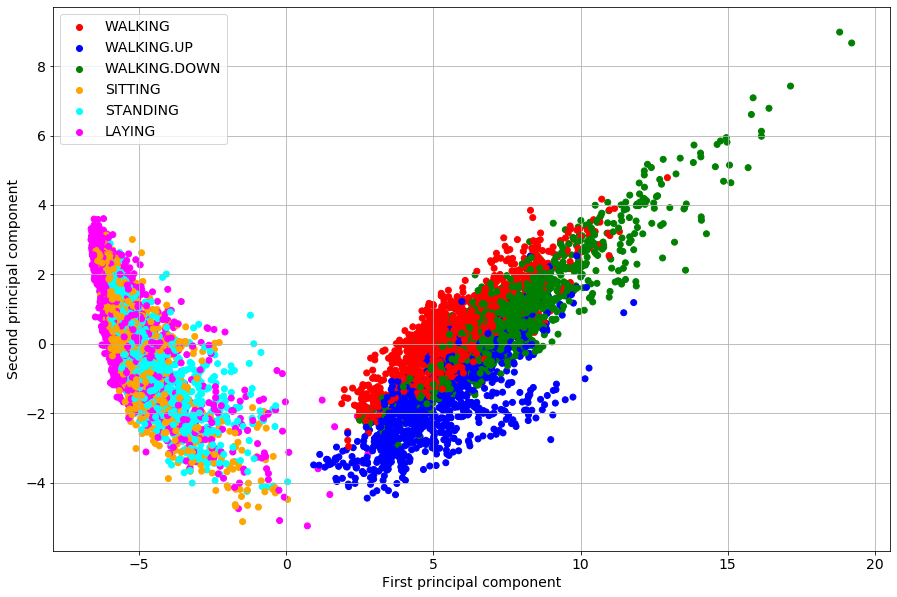

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Очень важно перемешать датасет! Данные идут в порядке классов. 

In [ ]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [ ]:
print(y_train[69])

tensor([3], dtype=torch.int32)


In [ ]:
def get_batches(X, y, batch_size):
  X = X.permute(0,2,1)
  X = X[:(len(X)//batch_size)*batch_size]
  y = y[:(len(X)//batch_size)*batch_size]
  for i in range(0, len(X), batch_size):
    yield X[i:(i+batch_size)], y[i:(i+batch_size)]

Для начала попробуем сделать CNN, как в первом пункте лабы.

In [ ]:
seq_len = 128
batch_size = 16

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv1d(9, 18, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv1d(18, 36, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv1d(36, 72, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv1d(72, 144, kernel_size = 3, stride = 1, padding = 1)
    self.out = nn.Linear(144 * 8, n_classes)

  def forward(self, x):
    x = F.relu(F.max_pool1d(self.conv1(x), 2))
    #print(x.size())
    x = F.relu(F.max_pool1d(self.conv2(x), 2))
    #print(x.size())
    x = F.relu(F.max_pool1d(self.conv3(x), 2))
    #print(x.size())
    x = F.relu(F.max_pool1d(self.conv4(x), 2))
    x = x.view(x.size(0), -1)
    x = F.log_softmax(self.out(x))
    return x

In [ ]:
learning_rate = 0.000146

net = CNN()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [ ]:
n_epoches = 100

test_acc = []
test_losses = []
test_counter = [i*len(X_train) for i in range(n_epoches)]

train_acc = []
train_losses = []
train_counter = []

In [ ]:
def train(epoch):
  net.train()
  for i, (x, y) in enumerate(get_batches(X_train, y_train, batch_size = batch_size)):
    #print(i)
    
    y = y.long() 
    y = y.squeeze(1)
    x = x.to('cuda')
    y = y.to('cuda')
    optimizer.zero_grad()


    out = net(x)
    #print(y)
    #print(out)
    loss = F.nll_loss(out, y)

    loss.backward()
    optimizer.step()

    total = y.size(0)
    predicted = torch.max(out.data, 1)[1]
    correct = (predicted == y).sum().item()


    if i % 10 == 0:
      print('Train Epoch: {}, [{}/{}], Loss: {:.4f} Accuracy: {:.2f}%'.format(
          epoch, i*len(x), len(X_train),
           loss.item(), ((correct/total) * 100)))
      train_losses.append(loss.item())
      train_acc.append((correct/total) * 100)
      train_counter.append(i * batch_size + (epoch - 1)*len(X_train)) 
      torch.save(net.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
      

In [ ]:
def test():
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for x, y in get_batches(X_test, y_test, batch_size = batch_size):
      y = y.long() 
      x = x.to('cuda')
      y = y.to('cuda')
      out = net(x)
      test_loss += F.nll_loss(out, y.squeeze(1), size_average=False).item()
      pred = out.data.max(1, keepdim=True)[1]
      correct += pred.eq(y.data.view_as(pred)).sum()
  test_loss /= len(X_test)
  test_acc.append(100. * correct / len(X_test))
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(X_test),
    100. * correct / len(X_test)))
  return 100. * correct / len(X_test)
  
  

In [ ]:

net = CNN()
net = net.to('cuda')
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
for epoch in range(1, n_epoches + 1):
  train(epoch)
  accuracy = test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1, [0/7352], Loss: 1.7802 Accuracy: 25.00%
Train Epoch: 1, [160/7352], Loss: 1.7735 Accuracy: 6.25%
Train Epoch: 1, [320/7352], Loss: 1.7624 Accuracy: 25.00%
Train Epoch: 1, [480/7352], Loss: 1.7849 Accuracy: 12.50%
Train Epoch: 1, [640/7352], Loss: 1.7659 Accuracy: 31.25%
Train Epoch: 1, [800/7352], Loss: 1.7779 Accuracy: 12.50%
Train Epoch: 1, [960/7352], Loss: 1.6693 Accuracy: 56.25%
Train Epoch: 1, [1120/7352], Loss: 1.6566 Accuracy: 50.00%
Train Epoch: 1, [1280/7352], Loss: 1.6766 Accuracy: 37.50%
Train Epoch: 1, [1440/7352], Loss: 1.4992 Accuracy: 43.75%
Train Epoch: 1, [1600/7352], Loss: 1.5022 Accuracy: 37.50%
Train Epoch: 1, [1760/7352], Loss: 1.3944 Accuracy: 68.75%
Train Epoch: 1, [1920/7352], Loss: 1.3830 Accuracy: 31.25%
Train Epoch: 1, [2080/7352], Loss: 1.2756 Accuracy: 56.25%
Train Epoch: 1, [2240/7352], Loss: 0.9297 Accuracy: 81.25%
Train Epoch: 1, [2400/7352], Loss: 1.1090 Accuracy: 68.75%
Train Epoch: 1, [2560/7352], Loss: 0.9148 Accuracy: 68.75%
Train E

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2, [160/7352], Loss: 0.2840 Accuracy: 81.25%
Train Epoch: 2, [320/7352], Loss: 0.4584 Accuracy: 87.50%
Train Epoch: 2, [480/7352], Loss: 0.4617 Accuracy: 81.25%
Train Epoch: 2, [640/7352], Loss: 0.6585 Accuracy: 75.00%
Train Epoch: 2, [800/7352], Loss: 0.4895 Accuracy: 75.00%
Train Epoch: 2, [960/7352], Loss: 0.3411 Accuracy: 93.75%
Train Epoch: 2, [1120/7352], Loss: 0.2298 Accuracy: 100.00%
Train Epoch: 2, [1280/7352], Loss: 0.2583 Accuracy: 87.50%
Train Epoch: 2, [1440/7352], Loss: 0.5575 Accuracy: 56.25%
Train Epoch: 2, [1600/7352], Loss: 0.4218 Accuracy: 87.50%
Train Epoch: 2, [1760/7352], Loss: 0.4107 Accuracy: 81.25%
Train Epoch: 2, [1920/7352], Loss: 0.2937 Accuracy: 87.50%
Train Epoch: 2, [2080/7352], Loss: 0.4387 Accuracy: 81.25%
Train Epoch: 2, [2240/7352], Loss: 0.6140 Accuracy: 68.75%
Train Epoch: 2, [2400/7352], Loss: 0.2224 Accuracy: 93.75%
Train Epoch: 2, [2560/7352], Loss: 0.2634 Accuracy: 87.50%
Train Epoch: 2, [2720/7352], Loss: 0.7374 Accuracy: 56.25%
Tr

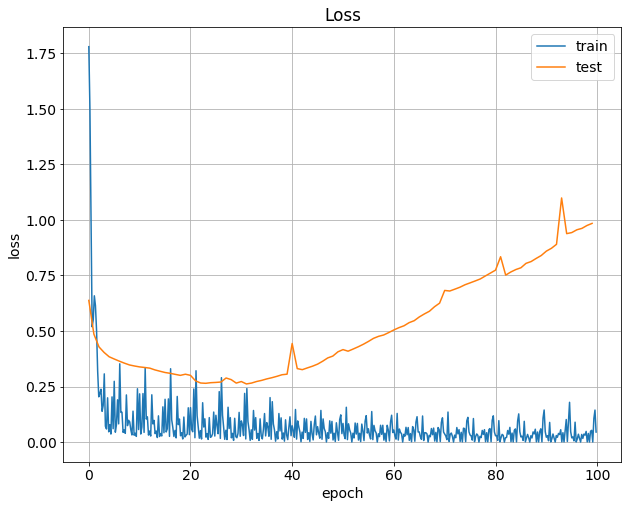

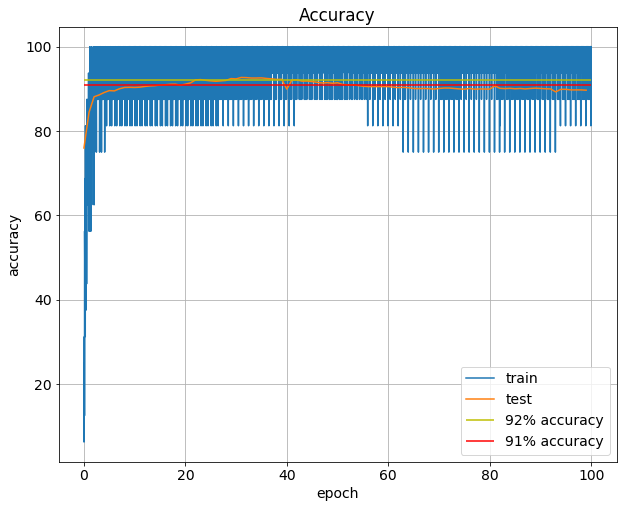

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(train_counter[::10]) / len(X_train), train_losses[::10], label='train')
plt.plot(np.array(test_counter)/ len(X_train), test_losses,  label='test')
plt.title("Loss")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(np.array(train_counter)/len(X_train), train_acc, label='train')
plt.plot(np.array(test_counter)/len(X_train), test_acc,  label='test')
plt.hlines(92, 0, 100, colors='y', label = '92% accuracy', zorder=10)
plt.hlines(91, 0, 100, colors='r', label = '91% accuracy', zorder=10)
plt.title("Accuracy")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()



*   Видим, что точность 92% на тесте достигается на достаточно большом количестве эпох (24-26; 30-40; 42;43)
*   Дальше наблюдается переобучение: лосс растет, точность падает. Постараемся разобраться с этим.



Добавим батчнорм. Дропаут использовать не будем, т.к. в оригинальной [статье](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) его использовали после fc слоев. У нас такой только один.

In [ ]:
class CNN_BN(nn.Module):
  def __init__(self):
    super(CNN_BN, self).__init__()
    self.conv1 = nn.Conv1d(9, 18, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv1d(18, 36, kernel_size = 3, stride = 1, padding = 1)
    self.conv2_bn = nn.BatchNorm1d(36)
    self.conv3 = nn.Conv1d(36, 72, kernel_size = 3, stride = 1, padding = 1)
    self.conv3_bn = nn.BatchNorm1d(72)
    self.conv4 = nn.Conv1d(72, 144, kernel_size = 3, stride = 1, padding = 1)
    self.conv4_bn = nn.BatchNorm1d(144)
    self.out = nn.Linear(144 * 8, n_classes)

  def forward(self, x):
    x = F.relu(F.max_pool1d(self.conv1(x), 2))
    #print(x.size())
    x = F.relu(F.max_pool1d(self.conv2_bn(self.conv2(x)), 2))
    #print(x.size())
    x = F.relu(F.max_pool1d(self.conv3_bn(self.conv3(x)), 2))
    #print(x.size())
    x = F.relu(F.max_pool1d(self.conv4_bn(self.conv4(x)), 2))
    x = x.view(x.size(0), -1)
    x = F.log_softmax(self.out(x))
    return x

In [ ]:
n_epoches = 100

test_acc = []
test_losses = []
test_counter = [i*len(X_train) for i in range(n_epoches)]

train_acc = []
train_losses = []
train_counter = []

In [ ]:
net = CNN_BN()
net = net.to('cuda')
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
for epoch in range(1, n_epoches + 1):
  train(epoch)
  accuracy = test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1, [0/7352], Loss: 2.1100 Accuracy: 6.25%
Train Epoch: 1, [160/7352], Loss: 1.4475 Accuracy: 62.50%
Train Epoch: 1, [320/7352], Loss: 1.0838 Accuracy: 62.50%
Train Epoch: 1, [480/7352], Loss: 0.8555 Accuracy: 81.25%
Train Epoch: 1, [640/7352], Loss: 0.7241 Accuracy: 93.75%
Train Epoch: 1, [800/7352], Loss: 0.5735 Accuracy: 87.50%
Train Epoch: 1, [960/7352], Loss: 0.7314 Accuracy: 87.50%
Train Epoch: 1, [1120/7352], Loss: 0.8043 Accuracy: 56.25%
Train Epoch: 1, [1280/7352], Loss: 0.6413 Accuracy: 75.00%
Train Epoch: 1, [1440/7352], Loss: 0.6275 Accuracy: 81.25%
Train Epoch: 1, [1600/7352], Loss: 0.5459 Accuracy: 68.75%
Train Epoch: 1, [1760/7352], Loss: 0.3208 Accuracy: 100.00%
Train Epoch: 1, [1920/7352], Loss: 0.5558 Accuracy: 75.00%
Train Epoch: 1, [2080/7352], Loss: 0.2343 Accuracy: 100.00%
Train Epoch: 1, [2240/7352], Loss: 0.4337 Accuracy: 87.50%
Train Epoch: 1, [2400/7352], Loss: 0.4245 Accuracy: 93.75%
Train Epoch: 1, [2560/7352], Loss: 0.2819 Accuracy: 93.75%
Train

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2827, Accuracy: 2689/2947 (91.25%)

Train Epoch: 2, [0/7352], Loss: 0.3301 Accuracy: 87.50%
Train Epoch: 2, [160/7352], Loss: 0.0988 Accuracy: 100.00%
Train Epoch: 2, [320/7352], Loss: 0.3778 Accuracy: 87.50%
Train Epoch: 2, [480/7352], Loss: 0.2540 Accuracy: 93.75%
Train Epoch: 2, [640/7352], Loss: 0.0996 Accuracy: 93.75%
Train Epoch: 2, [800/7352], Loss: 0.0534 Accuracy: 100.00%
Train Epoch: 2, [960/7352], Loss: 0.1819 Accuracy: 100.00%
Train Epoch: 2, [1120/7352], Loss: 0.2714 Accuracy: 81.25%
Train Epoch: 2, [1280/7352], Loss: 0.3650 Accuracy: 81.25%
Train Epoch: 2, [1440/7352], Loss: 0.1815 Accuracy: 93.75%
Train Epoch: 2, [1600/7352], Loss: 0.1103 Accuracy: 93.75%
Train Epoch: 2, [1760/7352], Loss: 0.0643 Accuracy: 100.00%
Train Epoch: 2, [1920/7352], Loss: 0.2514 Accuracy: 87.50%
Train Epoch: 2, [2080/7352], Loss: 0.0742 Accuracy: 100.00%
Train Epoch: 2, [2240/7352], Loss: 0.1678 Accuracy: 93.75%
Train Epoch: 2, [2400/7352], Loss: 0.2584 Accuracy: 93.75%


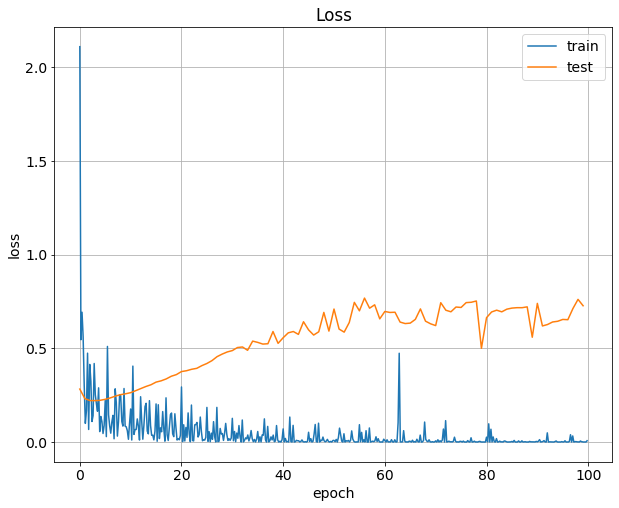

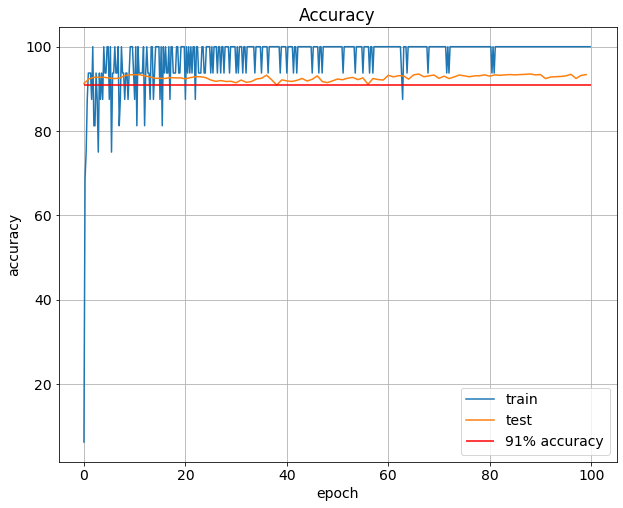

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(train_counter[::10]) / len(X_train), train_losses[::10], label='train')
plt.plot(np.array(test_counter)/ len(X_train), np.array(test_losses),  label='test')
plt.title("Loss")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(np.array(train_counter[::10])/len(X_train), train_acc[::10], label='train')
plt.plot(np.array(test_counter)/len(X_train), test_acc,  label='test')
#plt.hlines(92, 0, 100, colors='y', label = '92% accuracy', zorder=10)
plt.hlines(91, 0, 100, colors='r', label = '91% accuracy', zorder=10)
plt.title("Accuracy")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Видим, что батчнорм сильно помог. Теперь точность предсказаний не падает. Более того, она даже улучшилась. Лосс растет медленне, посел 40 эпохи держится примерно на одном уровне. Достигли 94% (например, на 99 эпохе).

### Часть 4. Optional. Dogs classification.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$96% - 2 points
* $>=$85% - 1.5 points
* $>=$70% - 0.75 points

## Загрузим данные

In [ ]:
import torchvision
from torchvision import datasets, transforms

def load_dataset(dataset):
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=16,
        num_workers=0,
        shuffle=True
    )

    return data_loader

In [ ]:
full_dataset = torchvision.datasets.ImageFolder(
    root='data/train/',
    transform = transforms.Compose([            
      transforms.Resize(256),                    
      transforms.CenterCrop(224),                
      transforms.ToTensor()
    ])                  
  )

In [ ]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
print('train size:' + str(train_size))
print('test size:' + str(test_size))

train size:2808
test size:703


In [ ]:
test_loader = load_dataset(test_dataset)
train_loader = load_dataset(train_dataset)

## Модель

Возьмем resnet-50 из предобученых моделей.

In [ ]:
from torchvision import models
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to('cuda')

In [ ]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Параметры уже обучены за нас.

In [ ]:
for param in resnet50.parameters():
    param.requires_grad = False

Заменим FС слой на 2 FC, чтобы  на выход шли нужные нам 50 классов.

In [ ]:
input = resnet50.fc.in_features

model = resnet50

model.fc = nn.Sequential(
    nn.Linear(input, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 50),
    nn.LogSoftmax(dim=1)
)

model = model.to('cuda')

Теперь архитектура сети выглядит следущим образом.

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Функции train и test немного изменим.

In [ ]:
def train(epoch):
  model.train()
  for i, (x, y) in enumerate(train_loader):
    
    y = y.long() 
    y = y
    x = x.to('cuda')
    y = y.to('cuda')
    optimizer.zero_grad()


    out = model(x)
    #print(y)
    #print(out)
    loss = F.nll_loss(out, y)

    loss.backward()
    optimizer.step()

    total = y.size(0)
    predicted = torch.max(out.data, 1)[1]
    correct = (predicted == y).sum().item()


    if i % 10 == 0:
      print('Train Epoch: {}, [{}/{}], Loss: {:.4f} Accuracy: {:.2f}%'.format(
          epoch, i*len(x), len(train_loader.dataset),
           loss.item(), ((correct/total) * 100)))
      train_losses.append(loss.item())
      train_acc.append((correct/total) * 100)
      train_counter.append(i * 16 + (epoch - 1)*len(train_loader.dataset)) 
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
      

In [ ]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for x, y in test_loader:
      y = y.long() 
      x = x.to('cuda')
      y = y.to('cuda')
      out = model(x)
      test_loss += F.nll_loss(out, y, size_average=False).item()
      pred = out.data.max(1, keepdim=True)[1]
      correct += pred.eq(y.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_acc.append(100. * correct / len(test_loader.dataset))
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)
  
  

In [ ]:
n_epoches = 50

test_acc = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epoches)]

train_acc = []
train_losses = []
train_counter = []

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.000146)
for epoch in range(1, n_epoches + 1):
  train(epoch)
  accuracy = test()

Train Epoch: 1, [0/2808], Loss: 3.9734 Accuracy: 0.00%
Train Epoch: 1, [160/2808], Loss: 3.7654 Accuracy: 6.25%
Train Epoch: 1, [320/2808], Loss: 3.6456 Accuracy: 12.50%
Train Epoch: 1, [480/2808], Loss: 3.3481 Accuracy: 18.75%
Train Epoch: 1, [640/2808], Loss: 3.2030 Accuracy: 18.75%
Train Epoch: 1, [800/2808], Loss: 3.6058 Accuracy: 6.25%
Train Epoch: 1, [960/2808], Loss: 3.0447 Accuracy: 25.00%
Train Epoch: 1, [1120/2808], Loss: 3.1631 Accuracy: 25.00%
Train Epoch: 1, [1280/2808], Loss: 3.0746 Accuracy: 18.75%
Train Epoch: 1, [1440/2808], Loss: 3.0192 Accuracy: 31.25%
Train Epoch: 1, [1600/2808], Loss: 3.7641 Accuracy: 6.25%
Train Epoch: 1, [1760/2808], Loss: 2.9013 Accuracy: 31.25%
Train Epoch: 1, [1920/2808], Loss: 2.8631 Accuracy: 43.75%
Train Epoch: 1, [2080/2808], Loss: 2.8887 Accuracy: 31.25%
Train Epoch: 1, [2240/2808], Loss: 2.5441 Accuracy: 62.50%
Train Epoch: 1, [2400/2808], Loss: 2.3130 Accuracy: 62.50%
Train Epoch: 1, [2560/2808], Loss: 2.2545 Accuracy: 56.25%
Train Epoc

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.0687, Accuracy: 502/703 (71.41%)

Train Epoch: 2, [0/2808], Loss: 2.3403 Accuracy: 56.25%
Train Epoch: 2, [160/2808], Loss: 2.1023 Accuracy: 62.50%
Train Epoch: 2, [320/2808], Loss: 2.1379 Accuracy: 62.50%
Train Epoch: 2, [480/2808], Loss: 2.4940 Accuracy: 56.25%
Train Epoch: 2, [640/2808], Loss: 2.1319 Accuracy: 62.50%
Train Epoch: 2, [800/2808], Loss: 1.9617 Accuracy: 68.75%
Train Epoch: 2, [960/2808], Loss: 2.1365 Accuracy: 62.50%
Train Epoch: 2, [1120/2808], Loss: 1.8590 Accuracy: 75.00%
Train Epoch: 2, [1280/2808], Loss: 2.5325 Accuracy: 43.75%
Train Epoch: 2, [1440/2808], Loss: 2.3812 Accuracy: 43.75%
Train Epoch: 2, [1600/2808], Loss: 1.9071 Accuracy: 62.50%
Train Epoch: 2, [1760/2808], Loss: 2.1568 Accuracy: 50.00%
Train Epoch: 2, [1920/2808], Loss: 1.8135 Accuracy: 75.00%
Train Epoch: 2, [2080/2808], Loss: 1.4257 Accuracy: 68.75%
Train Epoch: 2, [2240/2808], Loss: 1.5757 Accuracy: 56.25%
Train Epoch: 2, [2400/2808], Loss: 1.5567 Accuracy: 68.75%
Train E

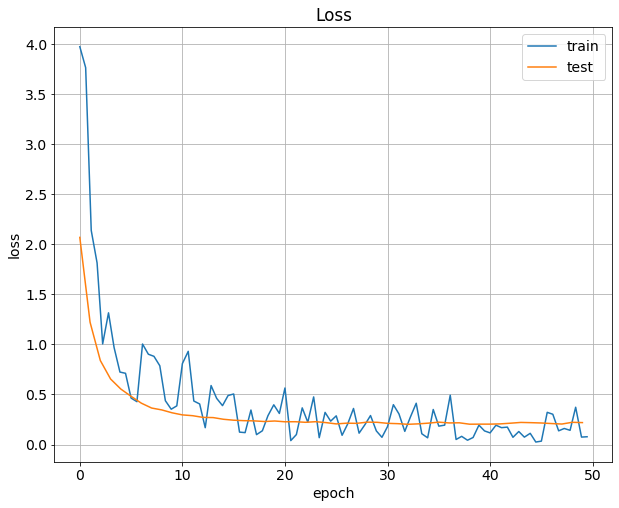

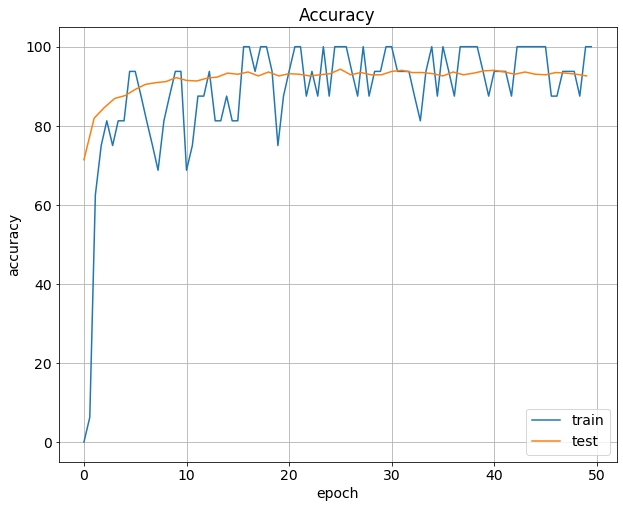

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(train_counter[::10]) / len(train_loader.dataset), train_losses[::10], label='train')
plt.plot(np.array(test_counter)/ len(train_loader.dataset), np.array(test_losses),  label='test')
plt.title("Loss")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(np.array(train_counter[::10])/len(train_loader.dataset), train_acc[::10], label='train')
plt.plot(np.array(test_counter)/len(train_loader.dataset), test_acc,  label='test')
#plt.hlines(92, 0, 100, colors='y', label = '92% accuracy', zorder=10)
#plt.hlines(91, 0, 100, colors='r', label = '91% accuracy', zorder=10)
plt.title("Accuracy")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

У нас получилась достаточно точная модель (точность 93-94%). По графикам видно, что переобучения нет. 

Вероятно, качеcтво модели можно улучшить, если добавить аугментцию данных.  Это увеличит объем датасета, что должно сильно повлиять на качество предсказаний, ведь данных для трейна у нас не очень много.
К сожалению, сделать это не хватило времени.



Напишем сам предсказатель.

In [ ]:
def predict(model, test_image):
     
 
    test_image = test_image.to('cuda')

     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image)
        prob = torch.exp(out)
        values, indices = prob.max(0)
        val, ind = values.max(0)
        print("Output class :  ", ind.item())

    return ind.item()

In [ ]:
def load_dataset(dataset):
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1503,  #size of test data
        num_workers=0,
        shuffle=False
    )

    return data_loader
#______________________________________________________________________________
# я создал папку test внутри папки test, в которой лежат данные для теста,
# чтобы пользоваться torchvision.datasets.ImageFolder
# не успел разобраться до дедлайна, как сделать это аккуратнее
load_test = load_dataset(test_dataset)


test_dataset = torchvision.datasets.ImageFolder(
    root='data/test',
    transform = transforms.Compose([            
      transforms.Resize(256),                    
      transforms.CenterCrop(224),                
      transforms.ToTensor()
    ])                  
  )

In [ ]:
dataiter = iter(load_test)
images, _ = dataiter.next()

Output class :   15


tensor(15, device='cuda:0')

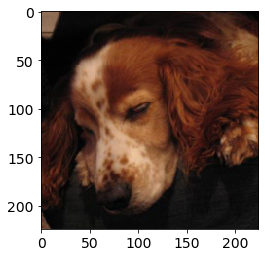

In [ ]:
import matplotlib.pyplot as plt
im2display = images[0].permute(1,2,0)
#sub.imshow(im2display, interpolation='nearest')
plt.imshow(im2display.numpy().squeeze(), interpolation='nearest')
predict(model, images[10].unsqueeze(0))

In [ ]:
classes_predicted = []

In [ ]:
f = open("out.csv", "x")
for i, image in enumerate(images):
  clAss = predict(model, image.unsqueeze(0))
  classes_predicted.append(clAss)
  f.write(str(i)+','+str(clAss)+'\n')
f.close()


Output class :   37
Output class :   23
Output class :   33
Output class :   10
Output class :   29
Output class :   19
Output class :   24
Output class :   13
Output class :   35
Output class :   8
Output class :   15
Output class :   4
Output class :   14
Output class :   13
Output class :   48
Output class :   4
Output class :   8
Output class :   34
Output class :   40
Output class :   32
Output class :   23
Output class :   36
Output class :   46
Output class :   48
Output class :   31
Output class :   32
Output class :   27
Output class :   5
Output class :   45
Output class :   7
Output class :   5
Output class :   19
Output class :   26
Output class :   29
Output class :   6
Output class :   27
Output class :   32
Output class :   16
Output class :   6
Output class :   49
Output class :   47
Output class :   27
Output class :   27
Output class :   12
Output class :   49
Output class :   27
Output class :   42
Output class :   21
Output class :   10
Output class :   27
Output cl

In [ ]:
from google.colab import files
files.download("out.csv")